In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from astropy import units as u
from scipy.integrate import solve_ivp
from astropy.constants import c, M_sun, G


plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


Surface radius: 8.886001706738876
Pressure at surface: 1.1304710659878623e-16
Mass at surface: 1.6017723871508676
Final raw pressure: 1.1304710659878623e-16
Final pressure: 1.698419729540164e-14 MeV / fm3


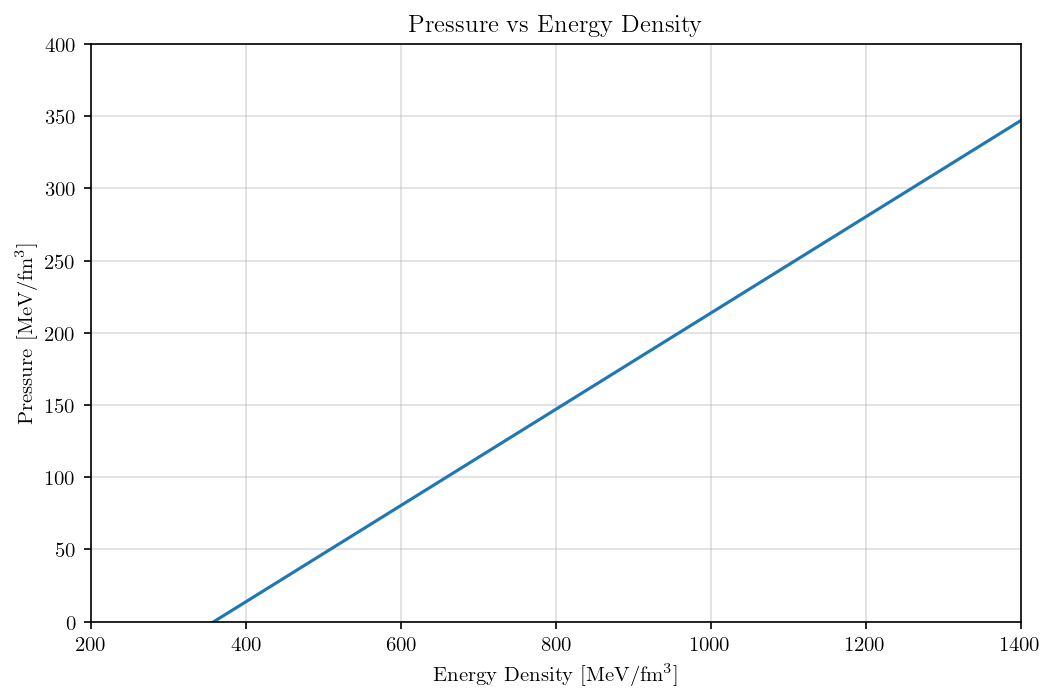

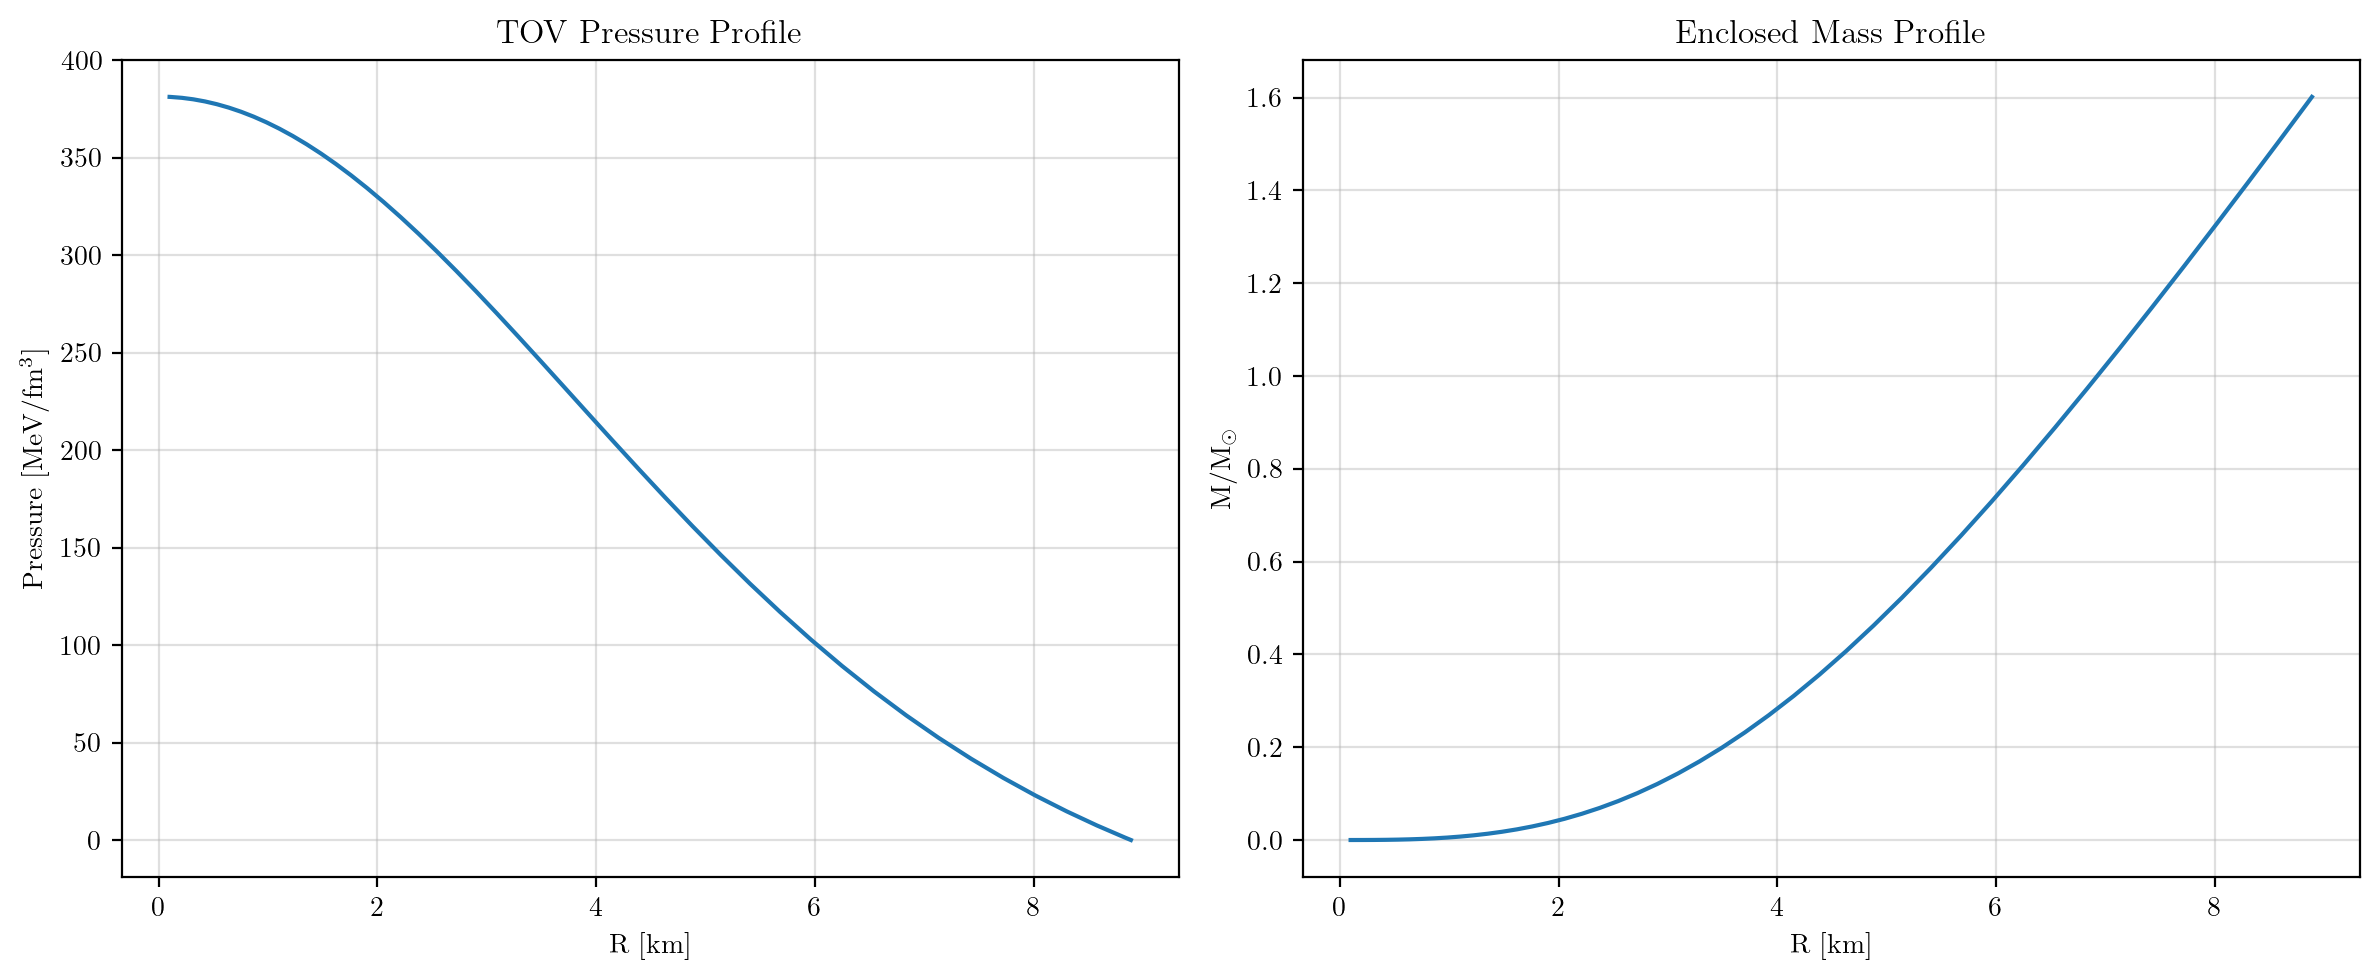

Star Radius (km): 8.886001706738876
Star Mass (M_sun): 1.6017723871508676


In [ ]:
#---- Saturation density and energy density ----

n_0 = 0.16 * u.fm**-3 # saturation density
m_0 = 939 * u.MeV / c**2  # neutron mass
e_0 = n_0 * m_0 * c**2 # saturation energy density

R_0 = (G * M_sun / c**2).to(u.km).value

# ---- EOS -------
def P(e):
    return (e - 4 * B) / 3

# ---- Constants ----

B_1_4 = 148 * u.MeV  # Bag constant to the 1/4 power
hc = 197.327 * u.MeV * u.fm

B_dim = B_1_4 ** 4 / hc**3
B = B_dim / e_0

e = np.linspace(0 , 10, 1000)
p = P(e)

plt.figure(figsize=(8,5), dpi=150)
plt.plot(e*e_0, p*e_0)
plt.ylim(0, 400)
plt.xlim(200,1400)
plt.xlabel('Energy Density [MeV/fm$^3$]')
plt.ylabel('Pressure [MeV/fm$^3$]')
plt.title('Pressure vs Energy Density')
plt.grid()

# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------

alpha = (4 * np.pi * e_0 / c**2 / M_sun).to(1/u.km**3).value

def ode_TOV(r, x):
    p, M = x
    if p < 0:
        # avoid negative pressure during integration
        return [0, 0]

    e = 3 * p + 4 * B   # inverse of example EOS

    # TOV terms
    term1 = R_0 * e * M / r**2
    term2 = 1 + p / e
    if M == 0:
        term3 = 1.0
    else:
        term3 = 1.0 + alpha * r**3 * p / M
    term4 = 1 - 2 * R_0 * M / r

    if term4 <= 0:
        return [0, 0]

    dpdr = - term1 * term2 * term3 / term4
    dMdr = alpha * r**2 * e

    return [dpdr, dMdr]



# ----------------------------------------------------
# Initial conditions
# ----------------------------------------------------
central_energy = 10.0   # in units of e0
central_pressure = P(central_energy)

r0 = 0.1             
central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
x0 = [central_pressure, central_mass]   # p(r0), M(r0)

# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative

# ----------------------------------------------------
# Solve ODE
# ----------------------------------------------------
sol = solve_ivp(
    ode_TOV,
    (r0, 20),     # integrate up to r=20 (large enough)
    x0,
    events=surface_event, 
    max_step=0.5,
    rtol=1e-8, atol=1e-10 #tolerance of the step size selection
)

# Extract full profiles (for plotting etc.)
radius = sol.t
pressure = sol.y[0]
mass = sol.y[1]

# Surface location from event
R_surface = sol.t_events[0][0] # 0, 0 because only one event
P_surface = sol.y_events[0][0][0] #stores the state vector at the event
M_surface = sol.y_events[0][0][1]

print("Surface radius:", R_surface)
print("Pressure at surface:", P_surface)   # Should be exactly 0
print("Mass at surface:", M_surface)

# If you also want the last raw solver step (not recommended)
final_pressure_raw = sol.y[0, -1]
print("Final raw pressure:", final_pressure_raw)
radius = sol.t
pressure = sol.y[0]
mass = sol.y[1]
final_pressure = sol.y[0, -1] * e_0
print("Final pressure:", final_pressure)

# ----------------------------------------------------
# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(radius, pressure*e_0)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV/fm$^3$]")
plt.title("TOV Pressure Profile")
plt.grid()

plt.subplot(1,2,2)
plt.plot(radius, mass)
plt.xlabel("R [km]")
plt.ylabel("M/M$_\odot$")
plt.title("Enclosed Mass Profile")
plt.grid()

plt.tight_layout()
plt.show()

print("Star Radius (km):", R_surface)
print("Star Mass (M_sun):", M_surface)




No surface event for central energy = 1.7
No surface event for central energy = 1.842211055276382
No surface event for central energy = 1.9844221105527637
No surface event for central energy = 2.126633165829146
No surface event for central energy = 2.2688442211055277


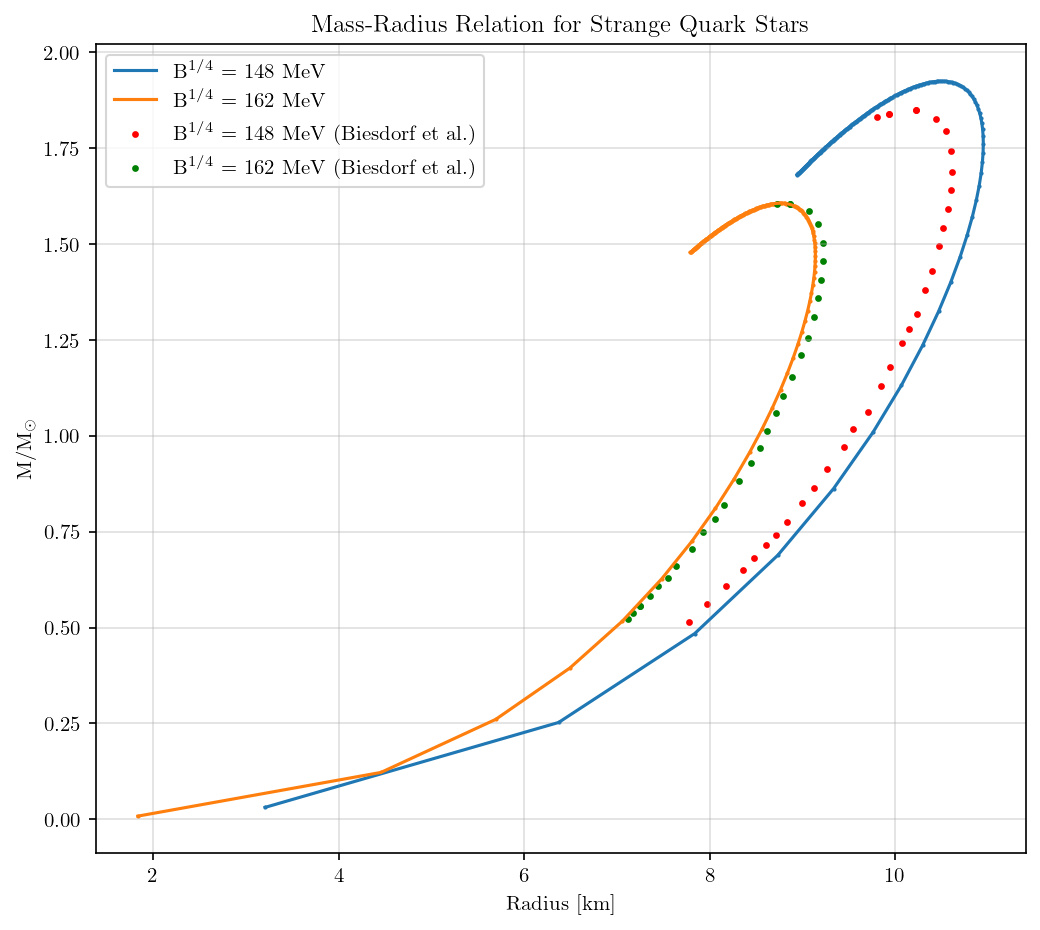

In [ ]:

central_energies = np.linspace(1.7, 30.0, 200) 


def solve_TOV(central_energy):
    # ----------------------------------------------------
    # Initial conditions
    # ----------------------------------------------------

    central_pressure = P(central_energy)
    r0 = 0.1            
    central_mass_density = (central_energy * e_0 / c**2 /M_sun).to(1/ u.km**3)
    central_mass = (4/3) * np.pi * r0**3 * central_mass_density.value
    x0 = [central_pressure, central_mass]   # p(r0), M(r0)

    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 100),     # integrate up to r=20 (large enough)
        x0,
        events=surface_event,
        max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface* e_0, 'MeV/fm^3')

    return R_surface, M_surface

B_1_4 = 148 * u.MeV 
B_dim = B_1_4 ** 4 / hc**3
B = B_dim / e_0

radii = []
masses = []
for ce in central_energies:
    R_star, M_star = solve_TOV(ce)
    radii.append(R_star)
    masses.append(M_star)
plt.figure(figsize=(8,7), dpi=150)
plt.plot(radii, masses, label ='B$^{1/4}$ = 148 MeV')
plt.scatter(radii, masses, s=1)
max_mass_mit = 1.87
max_rad_mit = 10.6
#plt.axhline(y=max_mass_mit, color='r', linestyle='--', label='Max Mass MIT Bmin (1.87 M$_\odot$)')
#plt.axvline(x=max_rad_mit, color='g', linestyle='--', label='Max Radius MIT Bmin  MIT (10.6 km)')

B_1_4 = 162 * u.MeV 
B_dim = B_1_4 ** 4 / hc**3
B = B_dim / e_0

radii = []
masses = []
for ce in central_energies:
    R_star, M_star = solve_TOV(ce)
    radii.append(R_star)
    masses.append(M_star)

plt.plot(radii, masses, label ='B$^{1/4}$ = 162 MeV')
plt.scatter(radii, masses, s=1)

max_mass_mit = 1.61
max_rad_mit = 9.22
#plt.axhline(y=max_mass_mit, color='r', linestyle='--', label='Max Mass MIT Bmax (1.61 M$_\odot$)')
#plt.axvline(x=max_rad_mit, color='g', linestyle='--', label=' Max Radius MIT Bmax (9.22 km)')


data = pd.read_csv('Bmin_biesdorf.csv')
data.sort_values
plt.scatter(data['x'], data[' y'], label='B$^{1/4}$ = 148 MeV (Biesdorf)', color='red', s=5)
data = pd.read_csv('Bmax_biesdorf.csv')
plt.scatter(data['x'], data[' y'], label='B$^{1/4}$ = 162 MeV (Biesdorf)', color='green', s=5)
plt.xlabel("Radius [km]")
plt.ylabel("M/M$_\odot$")
plt.title("Mass-Radius Relation for Strange Quark Stars")
plt.grid()
plt.legend()
plt.show()
